In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime, timedelta

# pip
import pickle
import xarray as xr
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# DEV: override installed teslakit
#import sys
#sys.path.insert(0,'../../')

# teslakit 
from teslakit.project_site import Site
from teslakit.pca import CalcRunningMean
from teslakit.pca import CalcPCA_latavg as CalcPCA
from teslakit.kma import KMA_simple, Persistences
from teslakit.statistical import CopulaSimulation

from teslakit.plotting.eofs import Plot_EOFs_latavg as PlotEOFs
from teslakit.plotting.kma import Plot_Weather_Types, Plot_WTs_Dates
from teslakit.plotting.kma import Plot_3D_3PCs_WTs, Plot_Compare_WTs_hist

from teslakit.alr import ALR_WRP
from teslakit.io.aux_nc import StoreBugXdset as sbxds
from teslakit.custom_dateutils import xds_reindex_daily as xr_daily
from teslakit.custom_dateutils import xds_reindex_monthly as xr_monthly


# --------------------------------------
# Site paths and parameters
data_folder = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
site = Site(data_folder, 'KWAJALEIN_TEST')

DB = site.pc.DB                        # common database
ST = site.pc.site                      # site database
PR = site.params                       # site parameters

# input files
p_SST = DB.SST.hist_pacific            # SST Pacific area 'SST_1854_2017_Pacific.nc'

# output files
p_sst_PCA = ST.SST.pca                 # SST Principal Component Analisis
p_sst_KMA = ST.SST.kma                 # SST KMeans Classification
p_sst_alrw = ST.SST.alrw               # SST Autoregressive Logistic Regression
p_PCs_sim = ST.SST.pcs_sim             # Simulated PCs
p_PCs_sim_d = ST.SST.pcs_sim_d         # Simulated PCs (daily data resolution)
p_PCs_sim_m = ST.SST.pcs_sim_m         # Simulated PCs (monthly data resolution)
p_export_figs = ST.export_figs.sst     # export figures


# PCA dates parameters
pred_name = 'SST'
y1 = int(PR.SST_AWT.pca_year_ini)
yN = int(PR.SST_AWT.pca_year_end)
m1 = int(PR.SST_AWT.pca_month_ini)
mN = int(PR.SST_AWT.pca_month_end)
num_clusters = int(PR.SST_AWT.num_clusters)
repres = float(PR.SST_AWT.repres)
num_PCs_rnd = int(PR.SST_AWT.num_pcs_rnd)

# Simulation dates (ALR)
y1_sim = int(PR.SIMULATION.date_ini.split('-')[0])
y2_sim = int(PR.SIMULATION.date_end.split('-')[0])



Calculating SST running average... 

Principal Component Analysis (latitude average)...
Principal Components Analysis COMPLETE
<xarray.Dataset>
Dimensions:        (n_components: 137, n_features: 972, n_lon: 81)
Dimensions without coordinates: n_components, n_features, n_lon
Data variables:
    PCs            (n_components, n_components) float64 7.972 ... 9.567e-15
    EOFs           (n_components, n_features) float64 -0.006245 ... -0.00497
    variance       (n_components) float64 467.5 99.72 ... 4.251e-05 9.22e-29
    pred_lon       (n_lon) float32 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
    var_anom_std   (n_features) float64 0.182 0.1846 0.2079 ... 0.9462 0.908
    var_anom_mean  (n_features) float64 0.004979 0.00597 ... 0.008235 0.008039
Attributes:
    method:   latitude averaged
    y1:       1880
    y2:       2016
    m1:       6
    m2:       5


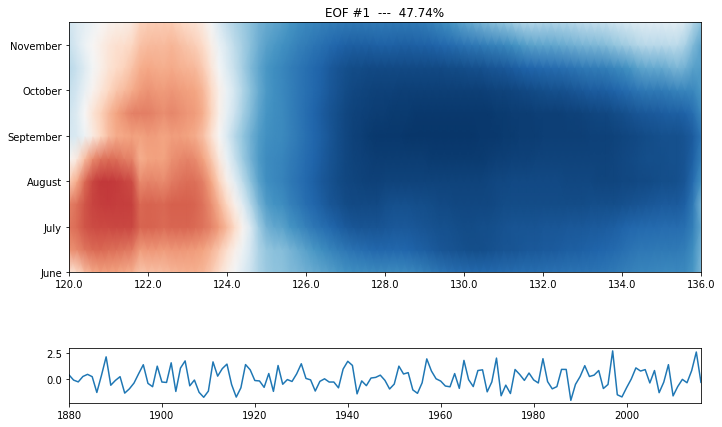

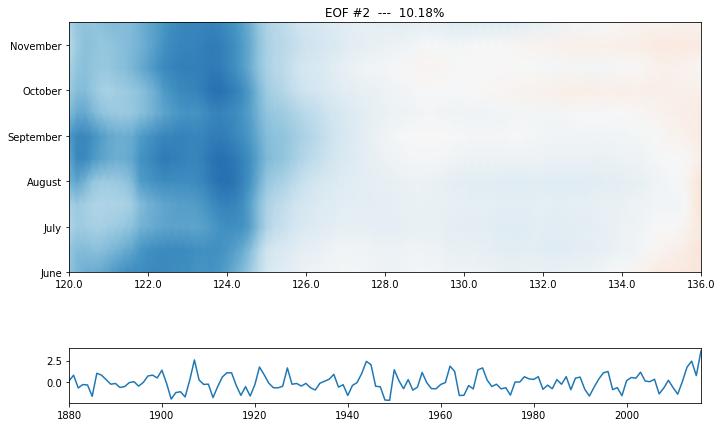

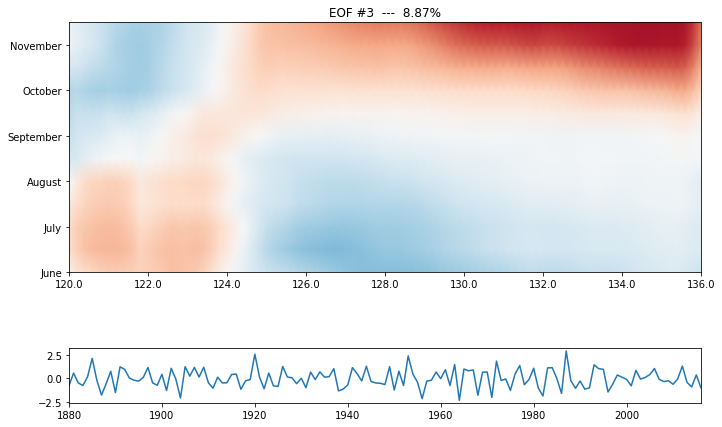

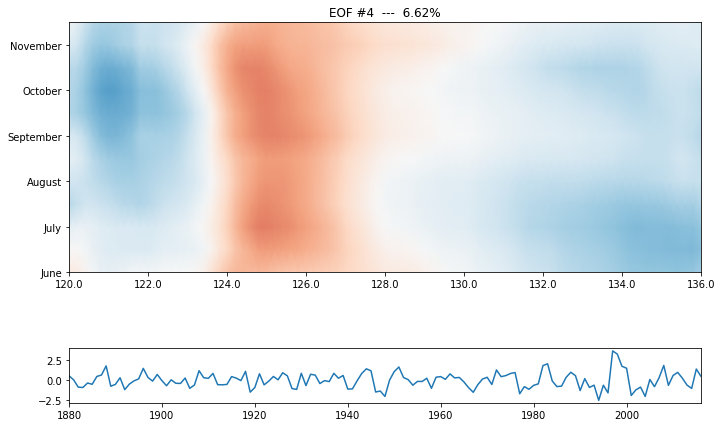

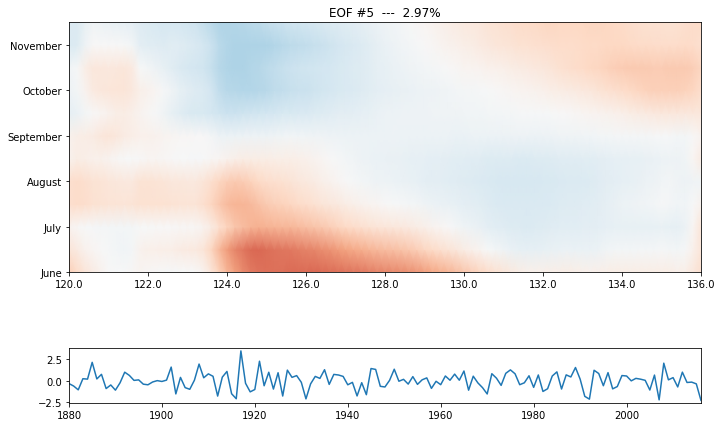

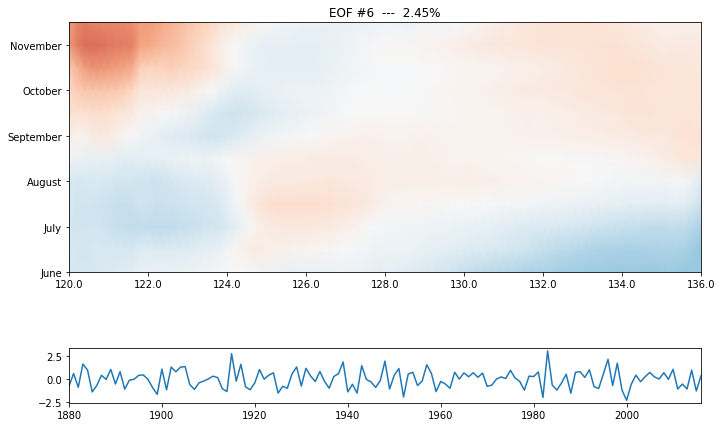

In [2]:
# --------------------------------------
# Principal Components Analysis SST data

# load SST predictor from database
xds_pred = xr.open_dataset(p_SST)

# Calculate running average
print('\nCalculating {0} running average... '.format(pred_name))
xds_pred = CalcRunningMean(xds_pred, pred_name)

# Principal Components Analysis
print('\nPrincipal Component Analysis (latitude average)...')
xds_PCA = CalcPCA(xds_pred, pred_name, y1, yN, m1, mN)
print(xds_PCA)

# plot EOFs
n_plot = 6
PlotEOFs(xds_PCA, n_plot)



KMA Classification...
<xarray.Dataset>
Dimensions:         (n_clusters: 6, n_features: 28, n_pcacomp: 137, n_pcafeat: 972)
Dimensions without coordinates: n_clusters, n_features, n_pcacomp, n_pcafeat
Data variables:
    order           (n_clusters) int64 4 1 5 3 2 0
    bmus_corrected  (n_pcacomp) int64 2 5 2 2 2 5 4 2 1 5 ... 5 0 4 4 5 3 0 1 3
    cenEOFs         (n_clusters, n_features) float64 -5.84 -1.546 ... -0.278
    bmus            (n_pcacomp) int32 5 0 5 5 5 0 2 5 1 0 ... 0 4 2 2 0 3 4 1 3
    centroids       (n_clusters, n_pcafeat) float64 -0.2265 -0.2992 ... 0.4204
    Km              (n_clusters, n_pcafeat) float64 -0.03625 -0.04927 ... 0.3898
    group_size      (n_clusters) int64 27 18 28 21 18 25
    PCs             (n_pcacomp, n_features) float64 7.972 1.668 ... -0.06965
    variance        (n_pcacomp) float64 467.5 99.72 86.87 ... 4.251e-05 9.22e-29

SST PCA and KMA stored at:
/Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN_TEST/SST/SST_PCA.nc
/Users/nico

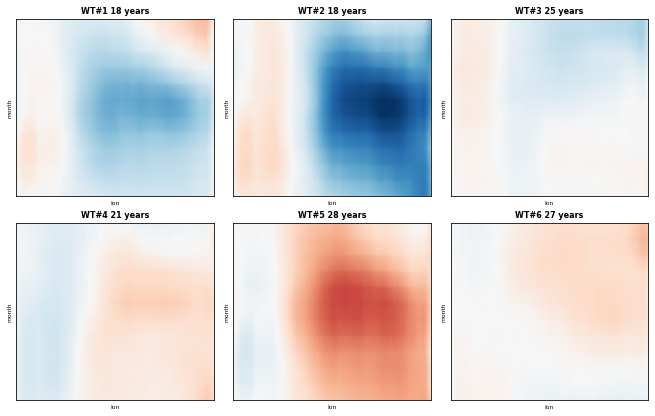

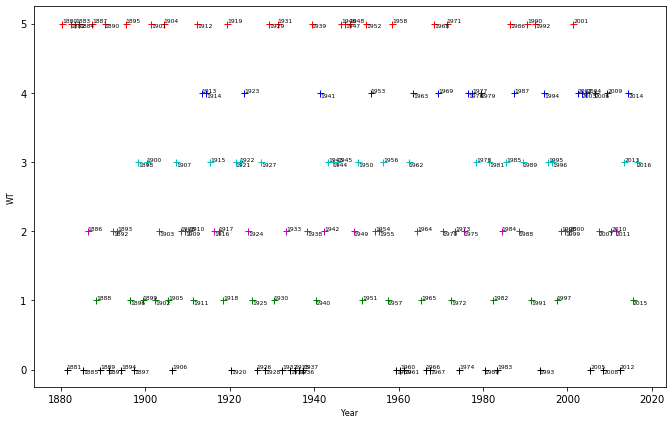

In [3]:
# --------------------------------------
# KMA Classification 

print('\nKMA Classification...')
xds_AWT = KMA_simple(
    xds_PCA, num_clusters, repres)
print(xds_AWT)

# PCA, KMA  dates (annual array)
dates_fit = [datetime(y,m1,1) for y in range(y1,yN+1)]
xds_PCA['time']=(('n_components'), dates_fit)
xds_AWT['time']=(('n_pcacomp'), dates_fit)

# store AWTs and PCs
xds_PCA.to_netcdf(p_sst_PCA,'w')  # store SST PCA data 
xds_AWT.to_netcdf(p_sst_KMA,'w')  # store SST KMA data 
print('\n{0} PCA and KMA stored at:\n{1}\n{2}'.format(
    pred_name, p_sst_PCA, p_sst_KMA))

# Plot Weather Types
Plot_Weather_Types(xds_AWT, xds_PCA.pred_lon)

# Plot year/label WTs
Plot_WTs_Dates(xds_AWT)

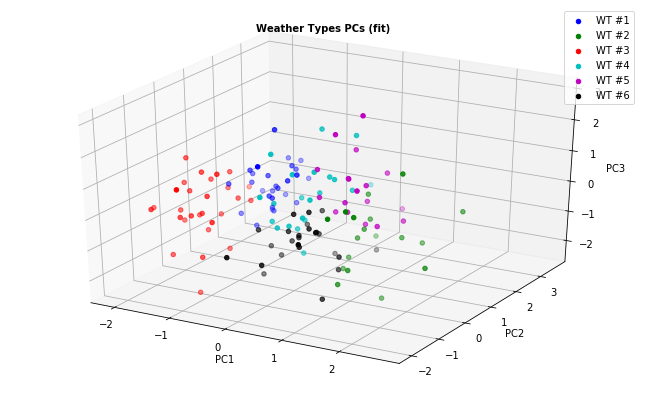

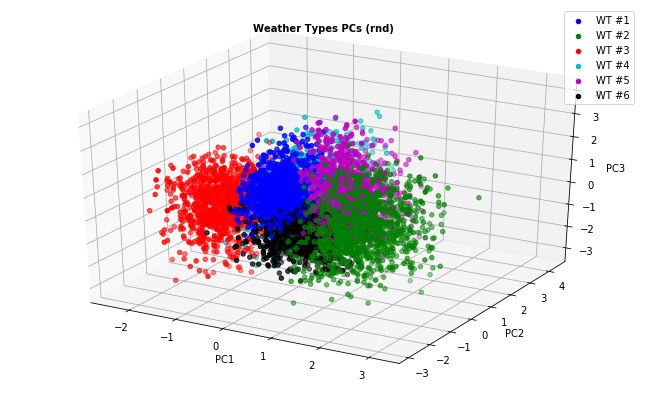

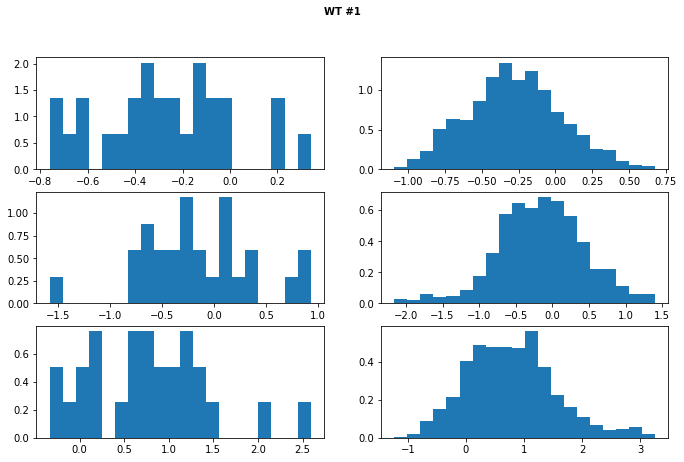

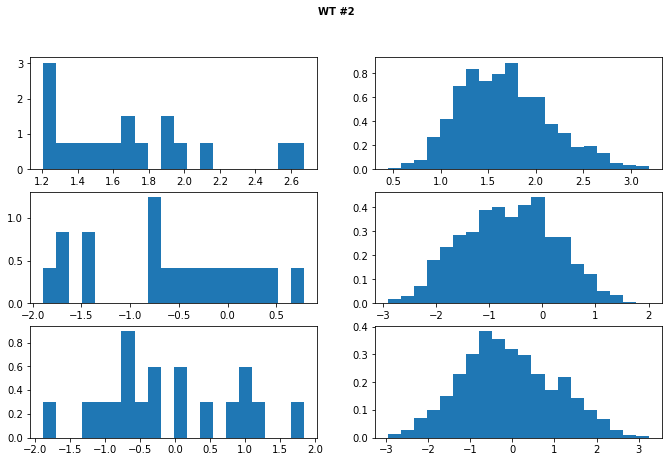

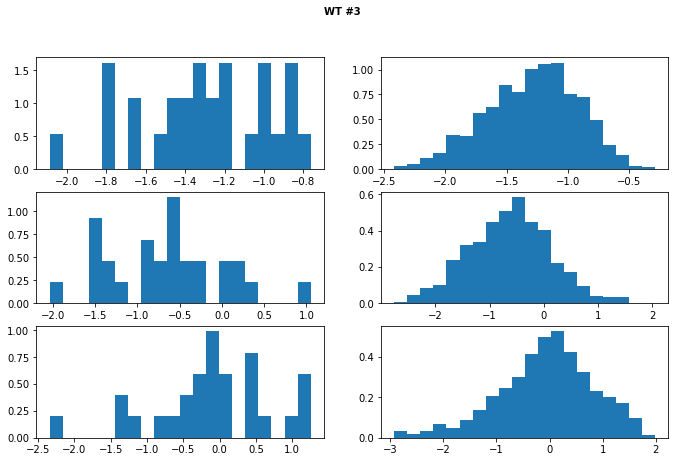

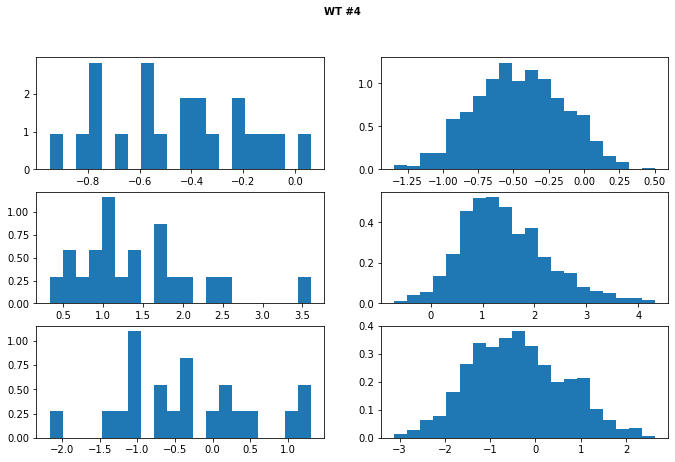

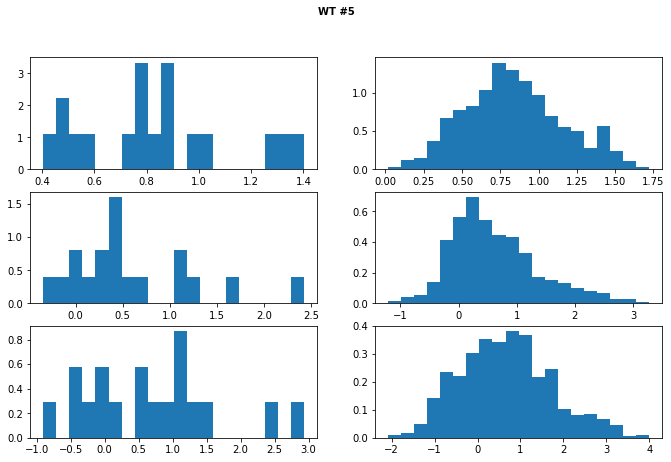

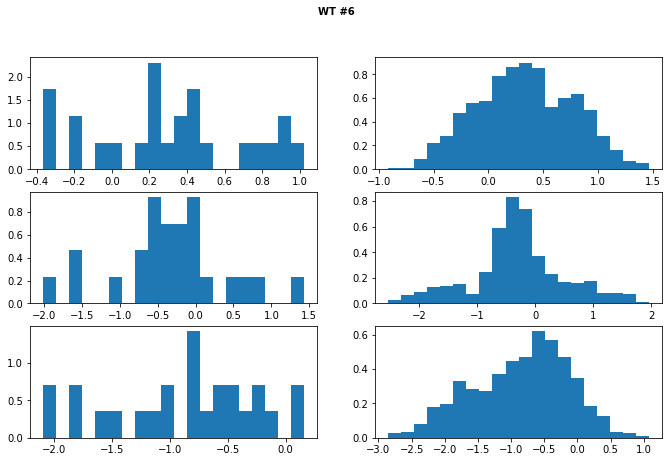

In [4]:
# --------------------------------------
# PCs123 random generation with Copulas

kma_order = xds_AWT.order.values
kma_labels = xds_AWT.bmus.values

# Get bmus Persistences
d_pers_bmus = Persistences(xds_AWT.bmus.values)

# first 3 PCs
PCs = xds_AWT.PCs.values
variance = xds_AWT.variance.values
PC1 = np.divide(PCs[:,0], np.sqrt(variance[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(variance[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(variance[2]))

# for each WT: generate copulas and simulate data 
d_pcs_fit = {}
d_pcs_rnd = {}
for i in range(num_clusters):

    # getting copula number from plotting order
    num = kma_order[i]

    # find all the best match units equal
    ind = np.where(kma_labels == num)[:]

    # PCs for weather type
    PC123 = np.column_stack((PC1[ind], PC2[ind], PC3[ind]))
    
    # statistical simulate PCs using copulas with KDE (kernel density estimation)
    kernels = ['KDE', 'KDE', 'KDE']
    PC123_rnd = CopulaSimulation(PC123, kernels, num_PCs_rnd)

    # store data 
    d_pcs_fit['WT #{0}'.format(num+1)] = PC123
    d_pcs_rnd['WT #{0}'.format(num+1)] = PC123_rnd
    
    
# store WTS PC123 fit and rnd
p_pick = op.join(p_export_figs, 'd_pcs_fit.pickle')
pickle.dump(d_pcs_fit, open(p_pick, 'wb'))
p_pick = op.join(p_export_figs, 'd_pcs_rnd.pickle')
pickle.dump(d_pcs_rnd, open(p_pick, 'wb'))


# Plot Weather Type 3D PCs for fit and random generation data
Plot_3D_3PCs_WTs(d_pcs_fit, 'Weather Types PCs (fit)')
Plot_3D_3PCs_WTs(d_pcs_rnd, 'Weather Types PCs (rnd)')

# Plot Weather Type histogram comparison for fit and random generation data
Plot_Compare_WTs_hist(d_pcs_fit, d_pcs_rnd)


In [5]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

xds_bmus_fit = xr.Dataset(
    {
        'bmus':(('time',), xds_AWT.bmus),
    },
    coords = {'time': xds_AWT.time.values}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : 1,
    'constant' : True,
    'long_term' : False,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(p_sst_alrw)
ALRW.SetFitData(num_clusters, xds_bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=10000)

# show fit report
# TODO: fix 
# ALRW.Report_Fit()



Fitting autoregressive logistic model ...
Optimization done in 0.10 seconds

ALR model saved at /Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN_TEST/SST/ALR/model.sav


In [6]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates (annual array)
dates_sim = [datetime(y,m1,1) for y in range(y1_sim,y2_sim+1)]

# launch simulation
sim_num = 1
xds_alr = ALRW.Simulate(sim_num, dates_sim, progress_bar=False)
evbmus_sim = np.squeeze(xds_alr.evbmus_sims.values[:])


# TODO: fix ALR bug, first evbmus_sim value is a 0 (has to be 1-6)
evbmus_sim[np.where(evbmus_sim==0)]=1



# Generate random PCs
print('\nGenerating PCs simulation: PC1, PC2, PC3 (random value withing category)...')
pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
for c, m in enumerate(evbmus_sim):
    options = d_pcs_rnd['WT #{0}'.format(int(m))]
    r = np.random.randint(options.shape[0])
    pcs123_sim[c,:] = options[r,:]

# denormalize simulated PCs
PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(variance[0]))
PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(variance[1]))
PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(variance[2]))

# store simulated PCs
xds_PCs_sim = xr.Dataset(
    {
        'PC1'  :(('time',), PC1_sim),
        'PC2'  :(('time',), PC2_sim),
        'PC3'  :(('time',), PC3_sim),
    },
    {'time' : dates_sim}
)

# xarray.Dataset.to_netcdf() wont work with this time array and time dtype
sbxds(xds_PCs_sim, p_PCs_sim)
print('\nSST PCs Simulation (yearly) stored at:\n{0}'.format(p_PCs_sim))

# resample to daily and store
xds_PCs_sim_d = xr_daily(xds_PCs_sim)
sbxds(xds_PCs_sim_d, p_PCs_sim_d)
print('\nSST PCs Simulation (daily) stored at:\n{0}'.format(p_PCs_sim_d))

# resample to monthly and store
xds_PCs_sim_m = xr_monthly(xds_PCs_sim)
sbxds(xds_PCs_sim_m, p_PCs_sim_m)
print('\nSST PCs Simulation (monthly) stored at:\n{0}'.format(p_PCs_sim_m))


ALR model fit   : 1880-06-01T00:00:00.000000000 --- 2016-06-01T00:00:00.000000000
ALR model sim   : 2020-06-01 00:00:00 --- 3020-06-01 00:00:00

Launching simulations...


Generating PCs simulation: PC1, PC2, PC3 (random value withing category)...

SST PCs Simulation (yearly) stored at:
/Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN_TEST/SST/SST_PCs_sim.nc

SST PCs Simulation (daily) stored at:
/Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN_TEST/SST/SST_PCs_sim_d.nc

SST PCs Simulation (monthly) stored at:
/Users/nico/Projects/TESLA-kit/TeslaKit/data/sites/KWAJALEIN_TEST/SST/SST_PCs_sim_m.nc
